# Behavioral cloning with Keras

The goal of this project to build and train a deep nueral network to learn from human driving. This algorithm will be used in a simulator environment with a vehicle equipped with 3 cameras and can get steering angle as a control signal.
The objective here is to train the model to use these 3 cameras output and feed the correct steering angle to the vehicle.

## Dataset
I used the dataset collected by Udacity. 
Here are the steps you'll take to build the network:
+ First load the data.
+ Append all recordings into a dataFormat structure. 
+ Split all features and labels into two sets. 1- Training (80%) 2- Validation (20%)

The following is the property of our loaded dataset:
+ center image
+ left image
+ right image
+ steer angle
+ throttle
+ break
+ speed


## Load the Data

Start by importing the data from the pickle file.

In [397]:
import numpy as np
import glob
import sys
import os.path
import fnmatch
import pandas as pd

data_dir = '/hamidb/applications/udacity-carnd/repo/data'
headers = ["center", "left", "right", "steer_angle",
           "throttle", "break", "speed"]
logs = []
for setpath in sorted(glob.glob(data_dir+"/")):
    setname = os.path.basename(setpath)
    for contents in os.listdir(setpath):
        if fnmatch.fnmatch(contents,'*.csv'):
            log_file = os.path.join(setpath, contents)
            
            log = pd.read_csv(log_file, header=None, delimiter=', ', names=headers, skiprows=1)
            logs.append(log)

logs = pd.concat(logs, axis=0, ignore_index=True)
#logs = shuffle(logs)#.reset_index(drop=True)
print(logs.shape)

# Get randomized datasets for training and test
log_train, log_valid = train_test_split(logs, test_size=0.20, random_state=43)

log_train = log_train#.reset_index(drop=True)
log_valid = log_valid#.reset_index(drop=True)
# Print out shapes of new arrays
train_size = log_train.shape[0]
valid_size = log_valid.shape[0]

print("train size:", train_size)
print("valid size:", valid_size)


(8036, 7)
train size: 6428
valid size: 1608


/hamidb/software/virtual_envs/env_py3_opencv_tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


# Data Augmentation
For better learning and ability to generalize, we needed to augment the currect dataset.
Our augmentation is not so complex since I did not have huge compute power to process all. I kept the network simple accordingly.

### Using left and right images
For each frame, we augment the center image with both left and right image to emulate deviation of the vehicle to the left and right sides of the road. Therefore, we also shifted the steering angle respectively. The amount we chose was '0.2' as the shift value to the steering angle.

### Flipping each frame
After some experiments, we found out that the trained network tends to steer more to either right or left side. We addressed this issue by balancing our dataset with even distribution of positive and negative steering angles.
A simple strategy for this is to augment the dataset with the flipped version of each frame along with it's negated steer angle.

### Crop and Resize
To discard useless parts of each frame such as sky, landscape, etc, we cropped header and footer pixels of all images.
In addition we reserved an option to resize each frame in order to bring down the complexity of our network.

The bellow figure, represents 6 different kinds of our augmnetation:

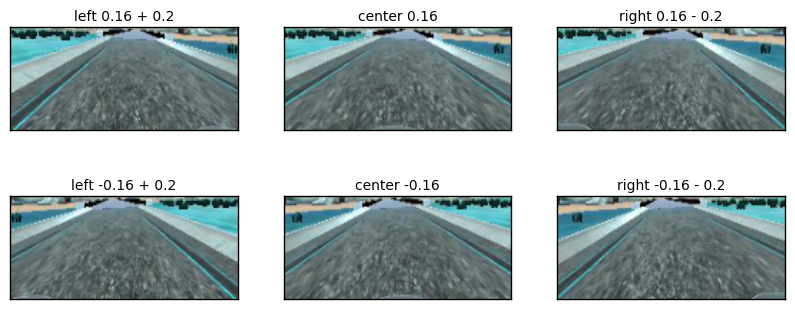

In [424]:
target_size = (72, 160)
fig = plt.figure(figsize=(10, 4)) 
i = 1
for flip in range(2):
    for name in ['left', 'center', 'right']:
        img = cv2.imread(os.path.join(data_dir, logs[name][72]))
        img = img[60:-20,:,:] # cropping
        img = cv2.flip(img, 1) if flip==1 else img
        img = cv2.resize(img, (target_size[1], target_size[0]))
        ax = fig.add_subplot(2, 3, i)
        ax.imshow(img)
        steer = round(logs['steer_angle'][72], 2)
        steer = -1.0*float(steer) if flip==1 else steer
        txt = " " + str(steer)
        if name=='left':
            txt = txt + ' + 0.2'
        if name == 'right':
            txt = txt + ' - 0.2'
        plt.title(name + txt , fontsize=10)
        ax.axes.get_xaxis().set_visible(False) # hide x tick labels
        ax.axes.get_yaxis().set_visible(False) # hide y tick labels
        i = i + 1
        

Since we will give a 3-channel input to the network, there is no need for BGR to RGB conversion.

# Batch generator
Since our dataset will be huge after augmentation, we will run out of memory and for higher efficiency we need to use a batch_generator function as follows:

In [398]:
# [ center:0, left: +correction, right: -correction]
steer_correction = [0, 0.2, -0.2]

def batch_generator(data, batch_size, target_size):
    while True:
        rand_inds = np.random.choice(len(data), size=int(batch_size/(2*3)))
        lrc_inds = np.random.choice(3, size=int(batch_size/(2*3)))
        features = []
        labels = []
        for cntr, left, right, steer, lrc, ind in zip(logs['center'][rand_inds],
                                                 logs['left'][rand_inds],
                                                 logs['right'][rand_inds],
                                                 logs['steer_angle'][rand_inds],
                                                 lrc_inds, rand_inds):
            for lrcs in range(3):
                img_name = (cntr, left, right)[lrcs]
                img = cv2.imread(os.path.join(data_dir, img_name))
                img = img[70:-25,:,:] # cropping
                img = cv2.resize(img, (target_size[1], target_size[0]))
                corrected_steer = steer + steer_correction[lrcs]
                labels.append(float(corrected_steer))
                features.append(img)
                # flipping
                labels.append(-1.0*float(corrected_steer))
                features.append(cv2.flip(img, 1))
        yield (np.array(features), np.array(labels))
            

# Network topology
It is clear in the bellow network that we used 2 convolutional layer and 3 fully connected layers. 2x2 maxpooling is also used after each conv layer.
We have also included cropping and normalization steps as tensors inside our network.

In [425]:
from keras.applications.vgg16 import VGG16 as vgg16
from keras.layers import Dense, Input, AveragePooling2D, Lambda, MaxPooling2D, Cropping2D
from keras.layers import Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Convolution2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

target_size = (160, 320)

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(*target_size, 3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(6, 5, 5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(16, 5, 5, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_59 (Lambda)               (None, 160, 320, 3)   0           lambda_input_55[0][0]            
____________________________________________________________________________________________________
cropping2d_14 (Cropping2D)       (None, 65, 320, 3)    0           lambda_59[0][0]                  
____________________________________________________________________________________________________
convolution2d_107 (Convolution2D (None, 61, 316, 6)    456         cropping2d_14[0][0]              
____________________________________________________________________________________________________
maxpooling2d_110 (MaxPooling2D)  (None, 30, 158, 6)    0           convolution2d_107[0][0]          
___________________________________________________________________________________________

In [392]:
# TODO: Compile and train the model here.
batch_size = 64
nb_epoch = 3

model.compile(loss='mse',
              optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['mean_absolute_error'])

train_generator = batch_generator(log_train, batch_size, target_size)
valid_generator = batch_generator(log_valid, batch_size, target_size)

batch_size_corrected = 6*int(batch_size/6)
samples_per_epoch = batch_size_corrected*int(2*len(log_train)/batch_size_corrected)
nb_val_samples = 6*5*batch_size_corrected
history = model.fit_generator(train_generator, samples_per_epoch=samples_per_epoch,
                              nb_epoch=nb_epoch, validation_data=valid_generator,
                              nb_val_samples=nb_val_samples)


Epoch 1/3
12840/12840 [==============================] - 3831s - loss: 0.0290 - mean_absolute_error: 0.1320 - val_loss: 0.0280 - val_mean_absolute_error: 0.1330
Epoch 2/3
12840/12840 [==============================] - 3862s - loss: 0.0234 - mean_absolute_error: 0.1196 - val_loss: 0.0228 - val_mean_absolute_error: 0.1170
Epoch 3/3
12840/12840 [==============================] - 3844s - loss: 0.0243 - mean_absolute_error: 0.1187 - val_loss: 0.0229 - val_mean_absolute_error: 0.1181


In [395]:
## import json
import h5py
from keras.backend import tf as ktf

with open('model.json', 'w') as f:
    json.dump(model.to_json(), f)

model.save('model.h5')

## Train the Network
Compile and train the network for 3 epochs. We used [`Adam`](https://keras.io/models/sequential/) optimizer, with `mse` loss function. The following parameters are used:
```
lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
```
We then used Keras's `.fit_generator()` method to have batch training with batch size of 64 sampes.

## Testing
Testing can be performed by running `drive.py` script given saved h5 files as follows:

```
$python drive.py model.h5
```
